# **03 - Correlation Analysis and Visualization**

## Objectives

* Analyze relationships between house attributes and the target variable `SalePrice`to identify key predictors for modeling.
* Validate hypotheses by performing correlation analysis and visualizing the results.
* Generate insights through visualization such as heatmaps, scatterplots and boxplots to demonstrate the strenght and direction of relationships.

## Inputs

* Cleaned dataset: `outputs/datasets/cleaned/house_prices_cleaned.csv`
* Hypotheses that can be found in [Hypotheses and Validation Process in README.md](LÄGG IN LÄNK!)

## Outputs

* Generate reusable code that answers **Business Requirement 1** by analyzing correlations and creating visualizations.
    * The code will aslo be used in the Streamlit app.
* Create and save data plots in `docs/plots` directory for use in Streamlit app.
* Identify and document the most relevant variables for the regression model based on the correlation analysis.

## Additional Comments

* The visualization in this notebook will also be used in the final dashboard to meed **Business Requirement 1**.


---

## Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

## Section 1: Load Data

Load the cleaned dataset from `outputs/datasets/cleaned/house_prices_cleaned.csv` into DataFrames and display the first five rows of the dataset.

In [ ]:
import pandas as pd

df = pd.read_csv("outputs/datasets/cleaned/house_prices_cleaned.csv")
df.head(5)

---

## Section 2: Data Exploration

We create a data profiling report for exploratory data analysis (EDA) of the DataFrame `df`.

In [ ]:
from ydata_profiling import ProfileReport

profile_report = ProfileReport(df=df, minimal=True)
profile_report.to_notebook_iframe()

Fix missing value for `GarageFinish` and check that no missing values remain.

In [ ]:
df['GarageFinish'].fillna('None', inplace=True)

print(df['GarageFinish'].isnull().sum())

---

## Section 3: Correlation and PPS Analysis

Our dataset includes four categorical variables stored as `object` data types. To incorporate these variables into the correlation analysis, we use One Hot Encoding to convert them into numerical format.

In [ ]:
from feature_engine.encoding import OneHotEncoder

encoder = OneHotEncoder(variables=df.columns[df.dtypes=='object'].to_list(), drop_last=False)
df_ohe = encoder.fit_transform(df)

print(df_ohe.shape)
df_ohe.head(5)

We define a set of functions to calculate and visualize the relationships between variables in the dataset. These functions generate heatmaps for correlation (Pearson and Spearman) and predictive power (PPS), offering insights into both linear, monotonic, and non-linear relationships. To maintain a clean and focused output, we suppress `FutureWarning` messages, which are not critical to the analysis but may clutter the console. The code ensures that the `docs/plots` directory exists, creating it if necessary, so that all generated plots are saved in an organized manner for easy access and future use. For clarity, heatmaps hide values that are 0 or less than 0.2, providing a cleaner and more interpretable visualization.

In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as pps
import warnings
%matplotlib inline

# Ignorera FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_theme(style="darkgrid")

# Check and create the folder to save plots
def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created.")

# Define correlation heatmap
def correlation_heatmap(df, threshold=0.5, figsize=(10, 8), font_size=8, title="Correlation Heatmap", save_path=None):
    """
    Generates a heatmap using correlation, filtering out weak correlations.
    """
    if df.shape[1] > 1:  # Check for enough columns
        # Filter rows and columns with values below the threshold
        filtered_data = df.loc[(abs(df) >= threshold).any(axis=1), (abs(df) >= threshold).any(axis=0)]

        # Create a mask to hide the upper triangle and values that are 0
        mask = np.zeros_like(filtered_data, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[(abs(filtered_data) <= 0.2)] = True

        # Format values to 2 decimal places
        formatted_data = filtered_data.applymap(lambda x: round(x, 2) if abs(x) > 0.2 else 0)

        # Draw heatmap
        plt.figure(figsize=figsize)
        sns.heatmap(
            formatted_data, 
            annot=True, 
            mask=mask, 
            cmap='viridis', 
            annot_kws={"size": font_size}, 
            linewidths=0.5
        )
        plt.title(title)

        # Save heatmap
        if save_path:
            ensure_directory_exists(os.path.dirname(save_path))  # Ensure directory exists
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Heatmap saved to {save_path}")
        
        plt.show()

# Define PPS heatmap
def pps_heatmap(df, threshold=0.2, figsize=(10, 8), font_size=8, title="PPS Heatmap", save_path=None):
    """
    Generates a heatmap for PPS matrices, filtering out weak predictive scores.
    """
    if df.shape[1] > 1:  # Check for enough columns
        # Filter rows and columns with values under the threshold
        filtered_data = df.loc[(abs(df) >= threshold).any(axis=1), (abs(df) >= threshold).any(axis=0)]

        # Create a mask to hide values <= 0.2 and values that are exactly 0
        mask = np.zeros_like(filtered_data, dtype=bool)
        mask[abs(filtered_data) <= 0.2] = True  # Mask values <= 0.2
        mask[filtered_data == 0] = True  # Mask values that are exactly 0

        # Format values to 2 decimal places
        formatted_data = filtered_data.applymap(lambda x: round(x, 2) if abs(x) > 0.2 else 0)

        # Draw heatmap
        plt.figure(figsize=figsize)
        sns.heatmap(
            formatted_data, 
            annot=True, 
            cmap='rocket_r', 
            annot_kws={"size": font_size}, 
            linewidths=0.5,
            mask=mask
        )
        plt.title(title)

        # Save heatmap
        if save_path:
            ensure_directory_exists(os.path.dirname(save_path))  # Ensure directory exists
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Heatmap saved to {save_path}")
        
        plt.show()

### Correlation Analysis

We start to calculate the Pearson and Spearman correlations.

In [ ]:
numeric_df = df.select_dtypes(include=[np.number])
spearman_corr = numeric_df.corr(method="spearman")
pearson_corr = numeric_df.corr(method="pearson")

Generates heatmaps for Spearman and Pearson method, hiding values that are 0 or less than 0.2.

In [ ]:
print("**Spearman heatmap**")
print("Evaluate monotonic relationships")
correlation_heatmap(
    df=spearman_corr,
    threshold=0.5,
    figsize=(20, 12),
    font_size=8,
    title="Spearman Correlation Heatmap",
    save_path="docs/plots/spearman_correlation_heatmap.png"
)
print("**Pearson heatmap**")
print("Evaluate linear relationships")
correlation_heatmap(
    df=pearson_corr,
    threshold=0.5,
    figsize=(20, 12),
    font_size=8,
    title="Pearson Correlation Heatmap",
    save_path="docs/plots/pearson_correlation_heatmap.png"
)

Calculates the Spearman correlation coefficients between the target variable `SalePrice` and all other columns in the `df_ohe` DataFrame, then sorts the results by absolute value in descending order, excluding the self-correlation of `SalePrice`.

In [42]:
spearman_corr = df_ohe.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:]
print("Top 10 Spearman correlations with SalePrice:")
spearman_corr.head(10)

Top 10 Spearman correlations with SalePrice:


OverallQual       0.809829
GrLivArea         0.731310
YearBuilt         0.652682
GarageArea        0.649379
GarageYrBlt       0.634095
TotalBsmtSF       0.602725
KitchenQual_TA   -0.581803
1stFlrSF          0.575408
YearRemodAdd      0.571159
KitchenQual_Gd    0.478583
Name: SalePrice, dtype: float64

Calculates the Pearson correlation coefficients between the target variable `SalePrice` and all other columns in the `df_ohe` DataFrame, then sorts the results by absolute value in descending order, excluding the self-correlation of `SalePrice`.

In [43]:
pearson_corr = df_ohe.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:]
print("\nTop 10 Pearson correlations with SalePrice:")
print(pearson_corr.head(10))


Top 10 Pearson correlations with SalePrice:
OverallQual       0.790982
GrLivArea         0.708624
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
YearBuilt         0.522897
KitchenQual_TA   -0.519298
YearRemodAdd      0.507101
KitchenQual_Ex    0.504094
MasVnrArea        0.472614
Name: SalePrice, dtype: float64


Combine the top 10 attributes from Pearson and Spearman and create a list for further analysis.

In [54]:
top_n = 10
vars_to_study = list(set(pearson_corr.head(top_n).index.to_list() + spearman_corr.head(top_n).index.to_list()))

print("\nVariables selected for further study:")
print(vars_to_study)


Variables selected for further study:
['YearBuilt', 'GarageYrBlt', 'YearRemodAdd', 'KitchenQual_Gd', 'MasVnrArea', 'GrLivArea', 'KitchenQual_Ex', 'GarageArea', 'TotalBsmtSF', 'OverallQual', '1stFlrSF', 'KitchenQual_TA']


### PPS Matrix

Calculate PPS Matrix.

In [47]:
pps_matrix_raw = pps.matrix(df)
pps_matrix = pps_matrix_raw.pivot(index='y', columns='x', values='ppscore')

Show PPS statistics

In [39]:
pps_stats = pps_matrix_raw.query("ppscore < 1")['ppscore'].describe()
print("PPS Statistics:\n", pps_stats.round(3))

PPS Statistics:
 count    462.000
mean       0.056
std        0.106
min        0.000
25%        0.000
50%        0.000
75%        0.066
max        0.891
Name: ppscore, dtype: float64


Generates heatmaps for PPS Matrix, hiding values that are 0 or less than 0.2 and saves plot to `docs/plots`.

*** PPS Matrix Heatmap ***
To detect both linear and non-linear relationships.
Heatmap saved to docs/plots/pps_heatmap.png


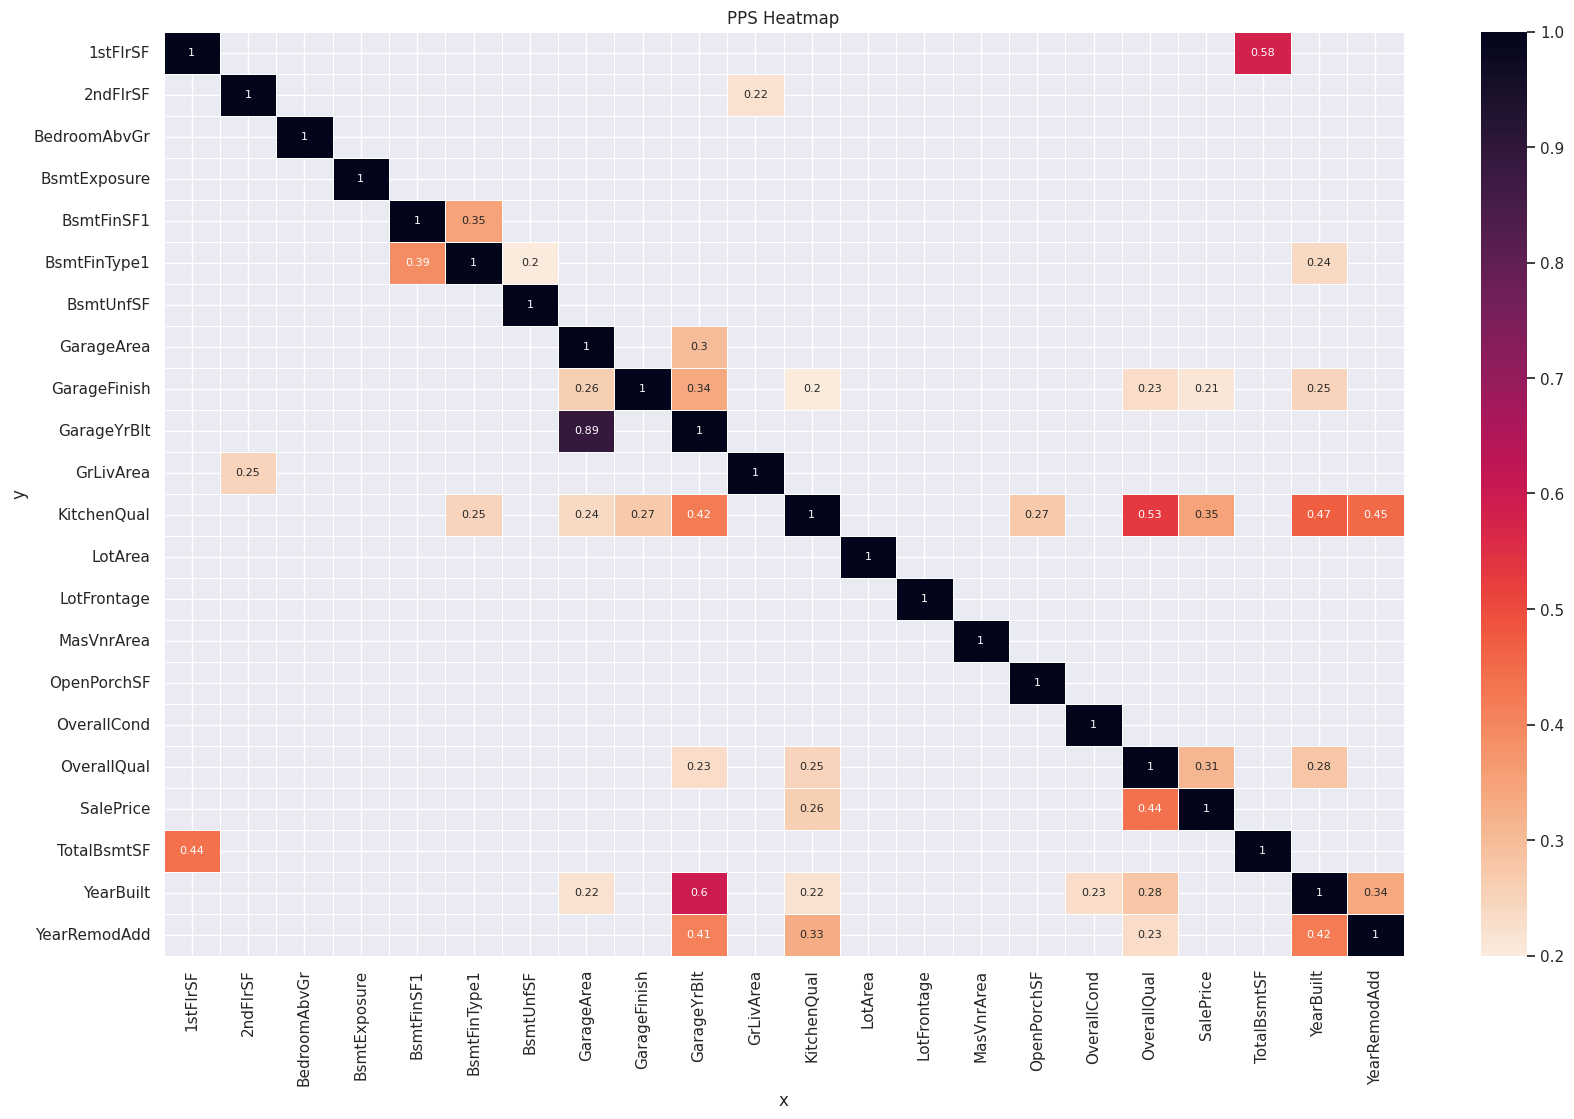

In [ ]:
print("*** PPS Matrix Heatmap ***")
print("To detect both linear and non-linear relationships.")
pps_heatmap(
    df=pps_matrix,
    threshold=0.2,
    figsize=(20, 12),
    font_size=8,
    title="PPS Heatmap",
    save_path="docs/plots/pps_heatmap.png"
)

---

## Section 4: Exploratory Data Analysis (EDA) on selected variables.

Combine the top 10 variables from Pearson, Spearman, and PPS.

In [52]:
top_n = 10
top_features = set(
    pearson_corr.head(top_n).index.to_list() +
    spearman_corr.head(top_n).index.to_list() +
    pps_matrix['SalePrice'].sort_values(ascending=False).head(top_n).index.to_list()
)

print("\nCombined top variables for further analysis:")
top_features


Combined top variables for further analysis:


{'1stFlrSF',
 'BsmtFinType1',
 'GarageArea',
 'GarageFinish',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual',
 'KitchenQual_Ex',
 'KitchenQual_Gd',
 'KitchenQual_TA',
 'MasVnrArea',
 'OverallQual',
 'SalePrice',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd'}

We create a new DataFrame (`df_eda`) containing the top 10 attributes along with the target variable `SalePrice`. This makes it easier to use these variables in further analysis or modeling.

In [55]:
selected_features = list(vars_to_study) + ['SalePrice']
df_eda = df_ohe[selected_features]

print("\nNew DataFrame for analysis:")
df_eda.head()


New DataFrame for analysis:


,YearBuilt,GarageYrBlt,YearRemodAdd,KitchenQual_Gd,MasVnrArea,GrLivArea,KitchenQual_Ex,GarageArea,TotalBsmtSF,OverallQual,1stFlrSF,KitchenQual_TA,SalePrice
0,2003,2003.0,2003,1,196.0,1710,0,548,856,7,856,0,208500
1,1976,1976.0,1976,0,0.0,1262,0,460,1262,6,1262,1,181500
2,2001,2001.0,2002,1,162.0,1786,0,608,920,7,920,0,223500
3,1915,1998.0,1970,1,0.0,1717,0,642,756,7,961,0,140000
4,2000,2000.0,2000,1,350.0,2198,0,836,1145,8,1145,0,250000


## Conclusions and Next Steps

### Conclusions
We successfully completed the data collection and initial exploration process, providing a clear understanding of the dataset's structure and potential challenges. Key findings include:
1. 

### Next steps: Data Cleaning
1. 

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
